In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# 1- Loading Data

In [31]:
filepath="../project/data/"
data = pd.read_csv(f"{filepath}train.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# 2- Dataset information


Training set information:
---------


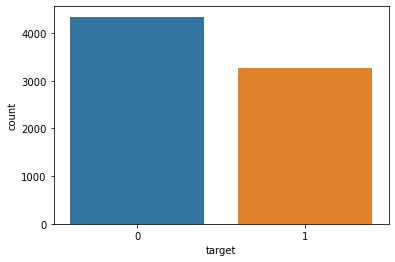

Input data has 7613 rows and, 5 column

Proportion of samples with label 1 (ie A real disaster tweet): 42.97 %
Proportion of samples with label 0 (ie Not a real disaster tweet): 57.03 %

Number of Missing Tweets = 0
Number of Missing Targets = 0


In [32]:
print("\nTraining set information:")
print("---------")
sns.countplot(x="target", data=data)
plt.show()

print(f'Input data has {len(data)} rows and, {len(data.columns)} column\n')

print("Proportion of samples with label 1 (ie A real disaster tweet):", np.round(data["target"].sum()/len(data)*100,2), "%")
print("Proportion of samples with label 0 (ie Not a real disaster tweet):", np.round((1-data["target"].sum()/len(data))*100,2),"%\n")


print(f'Number of Missing Tweets = {data["text"].isnull().sum()}')
print(f'Number of Missing Targets = {data["target"].isnull().sum()}')

# 3- Dataset Cleaning
As the text in these samples are tweets, there may be twitter handles or hashtags that are nonsense, but some handles for example could be for an emergency service account which can help us in our prediction. There also may be links in a tweet, which will not be as helpful and we can remove. 

The function will 
* remove the @ and # of handles and hashtags
* set text to lowercase
* remove html characters
* remove Emails ex. sebaiy@gmail.com
* convert apostrophe contractions to their full counterparts ex. i'm ==> i am
* remove hyperlinks
* remove stopwords
* remove punctuation 
* remove weird quirks from tweets such as "û_" and "vÌ_deo"

In [33]:
import html
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import ImageColorGenerator
import string

In [34]:
stop_words = set(stopwords.words('english'))

wnl = WordNetLemmatizer()  
set(string.punctuation)
stop_words.add('u')

Apos_dict={"'s":" is","won't":"will not", "can't":"cannot","n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}

def clean_text(text):
    
    text=text.lower()
    
    text=html.unescape(text) # remove html tag words
    
    for key,value in Apos_dict.items(): # remove contractions
        if key in text:
            text = text.replace(key,value)

    text=re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{1,4}\b", "", text) #emails like (sebaiy.mohamed@gmail.com)
    
    text=re.sub(r"[À-ÿ]+", "", text) #remove sympols like ([À, Ç, Ë,.., ÿ)
    
    text=re.sub(r'https?:\/\/.\S+', "",text)    # remove links
    
    text=re.sub(r'\S*û_*\S*|@\w*|#\w*', "",text) # remove u_, handles and just the hashtag froms hashtags
    
    text=re.sub(r'[0-9]', "", text) #remove numbers

    text=re.sub(r'[^\w\s]', "",text)# remove any character not in the set [^] ie punctuation, can add # | @ here

    no_stopwords = [i for i in  WhitespaceTokenizer().tokenize(text) if i not in stop_words]
    
    n_lemma = [wnl.lemmatize(i, pos= 'n') for i in  no_stopwords] # nouns Lemmatizations
    v_lemma = [wnl.lemmatize(i, pos= 'v') for i in  n_lemma] # verb Lemmatizations
    a_lemma = [wnl.lemmatize(i, pos= 'a') for i in  v_lemma] # adjectives Lemmatizations
    r_lemma = [wnl.lemmatize(i, pos= 'r') for i in  a_lemma] # adverbs Lemmatizations
    s_lemma = [wnl.lemmatize(i, pos= 's') for i in  r_lemma] # satellite adjectives Lemmatization
    
    # remove punctuation
    no_punct = []
    
    for word in s_lemma:
        s = ""
        for ch in word:
            if ch not in set(string.punctuation):
                s = f'{s}{ch}'
        no_punct.append(s)
        
    text = " ".join(no_punct)       
    return text

#print(f"An example\nThe uncleaned tweet: {data['text'].loc[71]}")
#print(f"The cleaned tweet: {clean_text(data['text'].loc[71])}")

In [35]:
cleaned_data = pd.DataFrame()

cleaned_data["text"] = data["text"].apply(clean_text)

cleaned_data["target"] = data["target"]
cleaned_data.head()

,text,target
0,deed reason may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident ask ishelter place notify officer eva...,1
3,people receive evacuation order california,1
4,get send photo ruby smoke pour school,1


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection

In [37]:
x_train_data, x_test_data, y_train, y_test = model_selection.train_test_split(cleaned_data["text"], cleaned_data["target"], test_size=0.2, random_state=0)

In [38]:
vectorisers={"tf_idf": TfidfVectorizer(stop_words='english',
                                                          analyzer="word",
                                                          ngram_range=(1,2),
                                                          max_features=None,
                                                          min_df=0.0004)}
vec = vectorisers["tf_idf"]
vec_train = np.array(cleaned_data["text"])
vec = vec.fit(np.array(vec_train))

x_train = vec.transform(np.array(x_train_data))
x_test = vec.transform(np.array(x_test_data))

In [39]:
print(f"Tweet: {cleaned_data['text'][5]}")
print('*******************************')
print(f"Vectorised tweet:\n{x_train[5]}")

Tweet: update california hwy close direction due lake county fire
*******************************
Vectorised tweet:
  (0, 3503)	0.23323725332601125
  (0, 3500)	0.17889076068258508
  (0, 3334)	0.23323725332601125
  (0, 3333)	0.23323725332601125
  (0, 2172)	0.23323725332601125
  (0, 2171)	0.16853688094673985
  (0, 2155)	0.23323725332601125
  (0, 2148)	0.23323725332601125
  (0, 2147)	0.2168556884220511
  (0, 1876)	0.2205761976011544
  (0, 1875)	0.20055797891123453
  (0, 1420)	0.23136077869138164
  (0, 1418)	0.18677444227126394
  (0, 383)	0.22790185949049177
  (0, 382)	0.18630876966113138
  (0, 321)	0.23323725332601125
  (0, 318)	0.20860519442993186
  (0, 237)	0.23323725332601125
  (0, 236)	0.21048166906456145
  (0, 153)	0.23323725332601125
  (0, 152)	0.22630010920855226


In [40]:
#import KNN model 
from sklearn.neighbors import KNeighborsClassifier

classifier=KNeighborsClassifier(n_neighbors =150, metric = 'minkowski', p = 2)

#train to model

classifier.fit(x_train, y_train)


KNeighborsClassifier(n_neighbors=150)

In [41]:
y_pred = classifier.predict(x_test)


In [42]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[784 102]
 [289 348]]


In [43]:
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.7432698621142482


# Navie Bayse model


In [52]:
#import Navie-Bayse model 
from sklearn.naive_bayes import BernoulliNB
classifiy = BernoulliNB()
classifiy.fit(x_train, y_train)


BernoulliNB()

In [53]:
y_pred = classifiy.predict(x_test)


In [54]:
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7866053841103086


In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[835  51]
 [274 363]]


# svm  model 


In [48]:
#Import svm model
from sklearn import svm



#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel



#Train the model using the training sets
clf.fit(x_train, y_train)



#Predict the response for test dataset
y_pred = clf.predict(x_test)

In [49]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7872619829284307


In [50]:
def tras(t):
    if t == 0:
        return "Not Disaster"
    return "Disaster"

In [51]:
t = pd.DataFrame({
    "tweet" : x_test_data,
    "True" : y_test,
    "predict" : y_pred 
})
t['True'] = t['True'].apply(tras)
t['predict'] = t['predict'].apply(tras)

t.head()

,tweet,True,predict
311,already know shit go world series armageddon,Not Disaster,Not Disaster
4970,people near meltdown comic free time wait line...,Not Disaster,Not Disaster
527,tix calgary flame v col avalanche preseason sc...,Not Disaster,Not Disaster
6362,ever think run choice life rembr kid choice we...,Not Disaster,Not Disaster
800,dotish blight car go right ahead mine,Not Disaster,Not Disaster
